In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

from functools import partial

from NormalizingFlows.src.train import train_backward_with_tuning, train_backward
from NormalizingFlows.src.scores import log_likelihood, difference_loglik
from NormalizingFlows.src.utils import update_device, load_best_model, load_checkpoint_model
from NormalizingFlows.src.flows import create_flows

from NormalizingFlows.src.structure.ar import AR 
from NormalizingFlows.src.structure.iar import IAR
from NormalizingFlows.src.structure.twoblock import TwoBlock

from NormalizingFlows.src.transforms.affine import Affine
from NormalizingFlows.src.transforms.piecewise import PiecewiseAffine
from NormalizingFlows.src.transforms.piecewise_additive import PiecewiseAffineAdditive
from NormalizingFlows.src.transforms.piecewise_affine import PiecewiseAffineAffine

from NormalizingFlows.src.data.toydata import ToyDataset

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device_cpu = torch.device("cpu")

In [90]:
#target_distr = torch.distributions.exponential.Exponential(torch.tensor([10.0]).to(device))
#target_distr = torch.distributions.gamma.Gamma(torch.tensor([1.0]).to(device), torch.tensor([5.0]).to(device))
#target_distr = torch.distributions.cauchy.Cauchy(torch.tensor([4.0]), torch.tensor([2.0]))
#dataset = ToyDataset(data_distr=target_distr, dim_input=4, samples=1000)

dataset = ToyDataset(dim_input=1)

In [91]:
dim_input = dataset.dim_input
num_trans = 5
perm_type = 'random'

In [92]:
dim_hidden = [126,126,105,105, 20, 10]

flows, names = [], []
#flows.append(create_flowsv(dim_input, dim_hidden, num_trans, perm_type, forward=False, structure=AR, 
#            transformation=PiecewiseAffine)), names.append('PAF')

#flows.append(create_flows(dim_input, dim_hidden, num_trans, perm_type, forward=False, structure=AR, 
#            transformation=PiecewiseAffineAdditive)), names.append('PAFAd')

#flows.append(create_flows(dim_input, dim_hidden, num_trans, perm_type, forward=False, structure=AR, 
#            transformation=PiecewiseAffineAffine)), names.append('PAFAf')

#flows.append(create_flows(dim_input, dim_hidden, num_trans, permtype, forward=False, structure=AR, 
#            transformation=Affine)), names.append('MAF')

#flows.append(create_flows(dim_input, dim_hidden, 2*num_trans, permtype, forward=False, structure=AR, 
#            transformation=Affine)), names.append('MAF-double')

#flows.append(create_flows(dim_input, dim_hidden, num_trans, perm_type, forward=False, structure=TwoBlock,
#            transformation=Affine)), names.append('Real NVP')

#flows.append(create_flows(dim_input, dim_hidden, 2*num_trans, perm_type, forward=False, structure=TwoBlock,
#            transformation=Affine)), names.append('Real NVP-double')

#flows.append(create_flows(dim_input, dim_hidden, num_trans, perm_type, forward=False, structure=TwoBlock,
#            transformation=PiecewiseAffine)), names.append('TwoBlock-PAF')

#flows.append(create_flows(dim_input, dim_hidden, num_trans, perm_type, forward=False, structure=TwoBlock,
#            transformation=PiecewiseAffineAdditive)), names.append('TwoBlock-PAFAd')

#flows.append(create_flows(dim_input, dim_hidden, num_trans, perm_type, forward=False, structure=TwoBlock,
#            transformation=PiecewiseAffineAffine)), names.append('TwoBlock-PAFAf')

for ind, flow in enumerate(flows):
    flow.name = names[ind]

In [22]:
tuning = False
if tuning:
    losses = []
    optimizers = []

    epochs = 200
    batch_size = 16
    num_hyperparam_samples = 4

    config = {
        'lr': tune.loguniform(1e-4, 1e-1),
        'weight_decay': tune.loguniform(1e-5, 1e-1)
    }
    scheduler = ASHAScheduler(
        time_attr='training_iteration',
        metric="loss",
        mode='min',
        max_t=epochs,
        grace_period=100,
        reduction_factor=2
    )
    reporter=CLIReporter(
        metric_columns=['loss', 'training_iteration']
    )

    for ind, flow in enumerate(flows):
        update_device(device_cpu, flow, dataset)
        result = tune.run(
            partial(train_backward_with_tuning, model=flow, dataset=dataset, epochs=epochs, batch_size=batch_size, print_n=epochs+1, name=names[ind]),
            config=config,
            num_samples=num_hyperparam_samples,
            scheduler=scheduler,
            progress_reporter=reporter,
            verbose=0
        )

        update_device(device_cpu, flow, dataset)


In [94]:
training = True
if training:
    losses = []
    optimizers = []

    epochs = 50
    batch_size = 16

    for i in range(len(flows)):
        flow = flows[i]
        update_device(device, flow, dataset)

        #optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3, weight_decay=1e-2)
        optimizer = torch.optim.SGD(flow.parameters(), lr=1e-4)
        optimizers.append(optimizer)

        losses.append(train_backward(flow, dataset.get_training_data(), optimizer, epochs, batch_size, print_n=200, save_checkpoint=True, burn_in=-1))

        update_device(device_cpu, flow, dataset)

Finished training. Loss for last epoch PAFAf2:      1.42060


In [82]:
#Additional training with same optimizer
additional_training = False
if additional_training:
    epochs = 200
    batch_size = 16
    add_flows, add_optimizers, add_losses = [], [], []
    for i in range(len(flows)):
        flow, optimizer, loss = load_checkpoint_model(flows[i], optimizers[i])
        add_flows.append(flow)
        add_optimizers.append(optimizer)
        add_losses.append(loss)
    
    flows, optimizers, losses = add_flows, add_optimizers, add_losses
    
    for i in range(len(flows)):
        flow = flows[i]
        update_device(device, flow, dataset)

        optimizer = optimizers[i]

        losses[i] += (train_backward(flow, dataset.get_training_data(), optimizer, epochs, batch_size, print_n=100, save_checkpoint=True, burn_in=1))

        update_device(device_cpu, flow, dataset)

Finished training. Loss for last epoch PAFAf2:     34.81393


In [95]:
best_flows = []
for flow in flows:
    best_flows.append(load_best_model(flow))

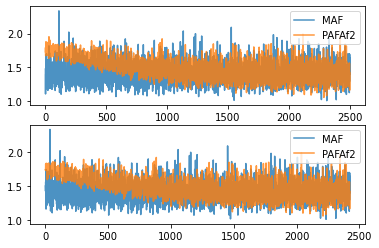

In [96]:
log_scale = False
from_iter = 75

plt.subplot(2,1,1)
for i in range(len(losses)):
    plt.plot(losses[i], label=names[i], alpha=0.8)
plt.legend()

plt.subplot(2,1,2)
for i in range(len(losses)):
    plt.plot((losses[i])[from_iter:], label=names[i], alpha=0.8)
plt.legend()

if log_scale:
    plt.yscale('log')

In [109]:
print('Results based on training data:' + '\n')

train_data = dataset.get_training_data()
mean_target = torch.mean(dataset.evaluate(train_data)).detach().numpy()
for flow in best_flows:
    log_lik, mean = log_likelihood(train_data, flow)
    print("Mean loglikelihood for {}: {}".format(str(flow), mean))
    print("Difference between target and {} mean loglikelihood: {}".format(str(flow), abs(mean-mean_target)))
    
    log_lik_diff, mean_diff, median_diff = difference_loglik(train_data, dataset, flow)
    print("Mean difference from target loglikelihood for {}: {}".format(str(flow), mean_diff))
    print("Median difference from target loglikelihood for {}: {} \n".format(str(flow), median_diff))
    

print("Mean loglikelihood with actual distribution: {}".format(mean_target))

Results based on training data:

Mean loglikelihood for MAF: [-1.417861]
Difference between target and MAF mean loglikelihood: [0.00136137]
Mean difference from target loglikelihood for MAF: [0.0013615608]
Median difference from target loglikelihood for MAF: [0.0023277998] 

Mean loglikelihood for PAFAf2: [-1.4204211]
Difference between target and PAFAf2 mean loglikelihood: [0.00119877]
Mean difference from target loglikelihood for PAFAf2: [-0.0011985562]
Median difference from target loglikelihood for PAFAf2: [-0.010354638] 

Mean loglikelihood with actual distribution: -1.419222354888916


In [106]:
print('Results based on test data' + '\n')

test_data = dataset.get_test_data()
mean_target = torch.mean(dataset.evaluate(test_data)).detach().numpy()
for flow in best_flows:
    log_lik, mean = log_likelihood(test_data, flow)
    print("Mean loglikelihood for {}: {}".format(str(flow), mean))
    print("Difference between target and {} mean loglikelihood: {}".format(str(flow), abs(mean-mean_target)))
    
    log_lik_diff, mean_diff, median_diff = difference_loglik(test_data, dataset, flow)
    print("Mean difference from target loglikelihood for {}: {}".format(str(flow), mean_diff))
    print("Median difference from target loglikelihood for {}: {} \n".format(str(flow), median_diff))
    

print("Mean loglikelihood with actual distribution: {}".format(mean_target))

Results based on test data

Mean loglikelihood for MAF: [-1.4366792]
Difference between target and MAF mean loglikelihood: [0.01578486]
Mean difference from target loglikelihood for MAF: [0.04362123]
Median difference from target loglikelihood for MAF: [0.033551037] 

Mean loglikelihood for PAFAf2: [-1.4350566]
Difference between target and PAFAf2 mean loglikelihood: [0.01740754]
Mean difference from target loglikelihood for PAFAf2: [0.06938923]
Median difference from target loglikelihood for PAFAf2: [0.07183409] 

Mean loglikelihood with actual distribution: -1.4524641036987305


In [108]:
print('Results based on new sample from each flow:' + '\n')

mean_target = torch.mean(dataset.evaluate(sample_last)).detach().numpy()
for flow in best_flows:
    with torch.no_grad():
        sample, log_prob = flow.sample(800)
        sample_last = sample[-1]
        
    log_lik, mean = log_likelihood(sample_last, flow)
    print("Mean loglikelihood for {}: {}".format(str(flow), mean))
    print("Difference between target and {} mean loglikelihood: {}".format(str(flow), abs(mean-mean_target)))
    
    log_lik_diff, mean_diff, median_diff = difference_loglik(sample_last, dataset, flow)
    print("Mean difference from target loglikelihood for {}: {}".format(str(flow), mean_diff))
    print("Median difference from target loglikelihood for {}: {} \n".format(str(flow), median_diff))


print("Mean loglikelihood with actual distribution: {}".format(mean_target))   

Results based on new sample from each flow:

Mean loglikelihood for MAF: [-1.399315]
Difference between target and MAF mean loglikelihood: [0.02282715]
Mean difference from target loglikelihood for MAF: [0.041308165]
Median difference from target loglikelihood for MAF: [0.035072982] 

Mean loglikelihood for PAFAf2: [-1.4155917]
Difference between target and PAFAf2 mean loglikelihood: [0.00655043]
Mean difference from target loglikelihood for PAFAf2: [0.07475222]
Median difference from target loglikelihood for PAFAf2: [0.07367635] 

Mean loglikelihood with actual distribution: -1.4221421480178833
